#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96 #  (submerged) [kg/m]

In [5]:
node_N = 200

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # 32219000   # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.84066249,  0.37502588, -0.39069446],
       [-0.47243145,  0.86052962, -0.1905185 ],
       [ 0.26475479,  0.34473811,  0.90058899]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.039955


In [29]:
Ret.shape

(200, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.001307


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[-3.86831451e+03, -3.55778451e+03,  1.38949406e+02],
       [-7.28018759e+03,  6.32771991e+03,  2.46325177e+04],
       [ 3.20817797e+03, -3.56082108e+03, -4.18782986e+03],
       [-1.87151433e+03,  3.79091320e+02, -7.74575389e+03],
       [ 6.73763435e+02, -2.73289114e+02, -8.38638360e+02],
       [ 5.19648192e+03,  1.03454650e+04,  9.34654310e+02],
       [ 2.18210109e+04,  2.58848081e+04, -3.27522615e+04],
       [-5.66476994e+03,  1.49898856e+04,  1.77839278e+03],
       [ 2.97591480e+03, -7.50105600e+03, -1.45522481e+03],
       [ 7.00775221e+03,  5.12331612e+03, -5.58749714e+03],
       [-3.21976869e+03, -2.47829367e+03,  4.81451028e+02],
       [-7.83736932e+03, -4.19531436e+03,  1.41406041e+04],
       [-1.26950268e+04,  6.54836691e+03,  1.40530403e+04],
       [ 7.40252539e+03, -9.38106140e+03,  6.24790666e+03],
       [ 4.31609040e+03,  5.74365351e+03, -4.89872003e+03],
       [-3.76440666e+03, -2.82587446e+03,  2.66896836e+03],
       [ 1.00384696e+04,  3.48238111e+03

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000440


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000389


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000180


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[-1.73451206e+02, -6.46477163e+01, -1.02049510e+02],
       [ 1.28102128e+02, -5.59583153e+01,  1.45726482e+02],
       [-6.39103148e+01, -2.26197426e+00,  3.99631948e+01],
       [ 6.09942773e+01,  1.35152637e+01, -1.52588389e+02],
       [ 7.87702179e+01,  4.53064156e+01, -1.21853663e+02],
       [-5.73119788e+00, -2.09279814e+02,  1.53228063e+02],
       [ 1.44572981e+01,  7.61717636e+01, -7.38663255e+00],
       [-5.52555958e+01, -9.34094147e+00, -1.37468453e+02],
       [-8.79123055e+00, -7.16811524e+01,  3.21989265e+01],
       [ 1.06690559e+02,  1.49784964e+02,  1.17620595e+02],
       [ 8.63711615e+01,  1.31521239e+02,  4.33941366e+01],
       [-1.10001917e+00, -3.63998142e+01, -2.12922352e+01],
       [-1.36505908e+02,  2.98249472e+01, -3.35653196e+01],
       [ 2.09181921e+02, -5.07138042e+01,  9.93186293e+00],
       [-4.33886384e+01, -1.67234160e-01,  7.69676876e+01],
       [ 1.02894699e+02, -1.81704503e+02,  5.34314838e+01],
       [-3.30392247e+01,  4.91080155e+01

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000282


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.014698


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.007886


In [57]:
ωe(φ,θ,ψ,None,None)

array([[ 3.52296081e-01, -3.14539488e-01, -2.96448116e-01],
       [-7.78760632e-01, -3.19894829e-01,  2.21518214e-01],
       [-2.66589249e-01, -6.75088380e-01, -4.88809334e-02],
       [-4.41592768e-02,  1.59260708e+00, -2.07290320e-01],
       [ 1.86252500e+00,  8.56286065e-01, -6.42196801e-01],
       [-2.54424491e-01, -2.20386332e-01,  5.21810658e-01],
       [-8.25339503e-01, -1.68369728e+00, -1.07422918e+00],
       [-5.98298448e-01, -7.40390059e-01,  8.06982453e-01],
       [-7.09171397e-02,  1.40013907e-01,  2.51421726e-01],
       [ 1.16400353e+00, -9.29012011e-02, -2.43123355e-01],
       [-4.47162971e-01, -1.03333232e+00, -7.87444752e-01],
       [ 1.50442281e+00,  3.29554607e-01, -7.33440886e-01],
       [-1.64297439e-01,  1.48615084e-01, -5.85762837e-02],
       [ 4.64961531e-01, -2.24181536e+00,  5.93178718e-01],
       [-5.65215067e-01, -3.67754130e-01, -2.88230544e-01],
       [-2.99085303e-01,  3.27524522e-01,  5.04733245e-01],
       [ 2.52412391e+00, -1.98723891e+00

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.29339071e+01, -3.42213630e+01, -2.70892565e+01,
        -2.40211774e+02, -7.52459564e+01,  7.54350686e+01,
         9.42627809e+01,  1.09318257e+02,  2.25304963e+01,
         2.54891267e+01,  5.87251445e+01, -3.37140662e+01,
        -3.24127813e+00,  7.81694556e+00, -2.83533877e+01,
         1.09212422e+02, -1.86944638e+02, -1.93947214e+01,
        -2.24802036e+01,  2.16150070e+02,  2.25617243e+01,
         3.80799749e+00, -5.06198951e+01,  2.79766417e+01,
         1.56146693e+01,  5.78141068e+02, -4.86521790e+01,
         3.20233713e+01, -2.55580298e+01, -1.08768235e+02,
         1.12211911e+02, -6.59287611e+01, -7.50548664e+01,
         8.98373738e+00, -6.67666954e+01, -7.15877239e+01,
        -1.86936322e+02,  4.48586525e+00, -5.69320202e+02,
         2.48813621e+00,  2.98577803e+00,  3.44818094e+02,
         1.15750104e+01, -1.33114577e+02, -8.73688118e+01,
         2.39545782e+02,  5.97813546e+01, -1.10137035e+02,
         5.28242409e+01,  7.69451666e+00,  1.54199099e+0

In [60]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.018898


In [61]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [62]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [63]:
ne_(dx,dy,dz,DT,Ret)

array([[ 3.86831451e+03,  7.28018759e+03, -3.20817797e+03,
         1.87151433e+03, -6.73763435e+02, -5.19648192e+03,
        -2.18210109e+04,  5.66476994e+03, -2.97591480e+03,
        -7.00775221e+03,  3.21976869e+03,  7.83736932e+03,
         1.26950268e+04, -7.40252539e+03, -4.31609040e+03,
         3.76440666e+03, -1.00384696e+04,  1.58330311e+03,
         1.37328163e+03, -6.89380956e+02,  6.45376643e+03,
         3.36742685e+03, -4.00499974e+03, -2.08772129e+02,
         4.05610940e+03, -3.59075726e+02, -4.50704877e+02,
         1.11513899e+04,  1.25255123e+04, -5.18670556e+03,
        -2.79747552e+03,  9.69758264e+02, -1.45064362e+03,
        -2.66935806e+03,  1.46264592e+03, -5.18881054e+02,
        -1.06448350e+04,  2.67468090e+04, -2.75665284e+03,
         1.67606597e+04, -2.49043802e+03,  4.85951486e+03,
         1.11122942e+04, -1.74278585e+03, -4.58243864e+03,
        -9.50283477e+02,  4.88012904e+01, -1.22971625e+03,
        -3.50226672e+03,  1.04566095e+04, -8.11254020e+0

In [64]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.026766


In [65]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 8.54645810e+09,  6.50489910e+10, -6.29359810e+10],
       [-1.19643087e+10,  3.09327986e+10,  4.15242359e+10],
       [-1.57654984e+10,  1.19751985e+10, -2.35672426e+10],
       [-4.09553298e+07, -1.90159479e+10, -1.58224420e+07],
       [-5.03367965e+10,  5.00751742e+09,  2.08109110e+09],
       [ 4.86121927e+10,  2.38252222e+10,  4.74055092e+10],
       [ 1.65294635e+10, -9.98482414e+09, -1.13987292e+09],
       [ 1.86723402e+10, -4.04927667e+10, -2.12188788e+10],
       [ 2.00486595e+10, -1.45307853e+08,  6.30082662e+09],
       [ 1.01542480e+09, -2.51755923e+10,  2.65224433e+10],
       [ 5.01258524e+09, -7.63003869e+09,  1.12482977e+09],
       [-2.77720550e+10,  7.52017597e+08, -4.67867244e+08],
       [-4.08549554e+09,  2.50094340e+09,  1.47799261e+10],
       [ 2.09408700e+09,  5.41411921e+10,  2.06527533e+11],
       [-2.64551914e+10,  3.82888536e+10, -9.84038656e+09],
       [ 8.26743937e+10,  4.86525140e+10,  1.77704174e+10],
       [-3.82231589e+10, -6.98566483e+10

In [66]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000406


In [67]:
Re_b(Ret).shape

(200, 3, 3)

In [68]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [69]:
Irho_e(Ret).shape

(200, 3, 3)

In [70]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000252


In [71]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [72]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [73]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [74]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.023835


In [75]:
d_me_

array([[-1.84297181e+02, -1.64254647e+02, -6.04727658e+01],
       [-1.12315575e+02,  1.72351294e+02, -6.75993835e+00],
       [-2.28521291e+01, -7.69187688e+00,  1.85645338e+02],
       [ 1.61372111e-01,  2.22870807e+01, -4.18840179e-03],
       [ 8.11815315e+02, -1.19193580e+02, -2.44689350e+02],
       [-8.54583002e+01,  1.82836951e+02,  4.65450997e+01],
       [-6.42225298e+02,  1.90590326e+03, -1.07753038e+02],
       [-7.72175104e+00,  5.26010373e+02,  8.84351028e+02],
       [-1.90926377e+00,  2.34240127e+01, -1.41474023e+01],
       [ 6.63510441e-02,  9.22279613e+01, -3.19340317e+01],
       [ 7.20683153e+00,  5.22445401e+01, -1.84115452e+01],
       [ 8.57118983e+02,  1.39613677e+01,  2.11081646e+01],
       [-1.44337257e+01, -1.46312497e+01,  3.25693602e+00],
       [ 1.07009267e+03,  5.44167746e+02,  5.72760441e+02],
       [-2.22770406e+02, -1.00730796e+02,  4.08776363e+02],
       [ 8.25194340e+02,  9.17909073e+02, -1.57806499e+02],
       [ 8.46097751e+02,  1.11636270e+03

In [76]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[ 3.86831451e+03,  7.28018759e+03, -3.20817797e+03,
         1.87151433e+03, -6.73763435e+02, -5.19648192e+03,
        -2.18210109e+04,  5.66476994e+03, -2.97591480e+03,
        -7.00775221e+03,  3.21976869e+03,  7.83736932e+03,
         1.26950268e+04, -7.40252539e+03, -4.31609040e+03,
         3.76440666e+03, -1.00384696e+04,  1.58330311e+03,
         1.37328163e+03, -6.89380956e+02,  6.45376643e+03,
         3.36742685e+03, -4.00499974e+03, -2.08772129e+02,
         4.05610940e+03, -3.59075726e+02, -4.50704877e+02,
         1.11513899e+04,  1.25255123e+04, -5.18670556e+03,
        -2.79747552e+03,  9.69758264e+02, -1.45064362e+03,
        -2.66935806e+03,  1.46264592e+03, -5.18881054e+02,
        -1.06448350e+04,  2.67468090e+04, -2.75665284e+03,
         1.67606597e+04, -2.49043802e+03,  4.85951486e+03,
         1.11122942e+04, -1.74278585e+03, -4.58243864e+03,
        -9.50283477e+02,  4.88012904e+01, -1.22971625e+03,
        -3.50226672e+03,  1.04566095e+04, -8.11254020e+0

### Vessel

In [78]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [79]:
V=VesselSemisub()

In [80]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [81]:
tau_force = V.tau(η,dη, ddη)

In [82]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [83]:
wave_coef=1

In [84]:
def Fx(x,dx, z,dz, t, kp, kd, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)-kp*(z-z_ref) - kd*(dz-dz_ref)

In [85]:
Hs = 2.5 # significant wave height in m

In [86]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [87]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [88]:

def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0, z_ref = 0, dz_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx,z,dz,time, kp, kd, x_ref, dx_ref, z_ref, dz_ref),0,0])
       +wave_coef*np.array([0,0,wave_force(Hs,d0,qw)])*np.sin(2*np.pi/Tp*time+1)
      ).T
    ans=np.concatenate( [F,[0,0,0]], axis=0)
    return ans

In [89]:
tau(η, dη, wave_coef, kp, kd,3)

array([9750.        ,    0.        , 7283.67179881,    0.        ,
          0.        ,    0.        ])

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
      

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  55.541129871666435,
  111.08225974333287,
  166.6233896149993,
  222.16451948666574,
  277.70564935833215,
  333.2467792299986,
  388.78790910166504,
  444.3290389733315,
  499.8701688449979,
  555.4112987166643,
  610.9524285883308,
  666.4935584599972,
  722.0346883316637,
  777.5758182033301,
  833.1169480749966,
  888.658077946663,
  944.1992078183293,
  999.7403376899958,
  1055.2814675616623,
  1110.8225974333286,
  1166.363727304995,
  1221.9048571766616,
  1277.445987048328,
  1332.9871169199944,
  1388.5282467916609,
  1444.0693766633274,
  1499.6105065349936,
  1555.1516364066601,
  1610.6927662783266,
  1666.2338961499931,
  1721.7750260216594,
  1777.316155893326,
  1832.8572857649924,
  1888.3984156366587,
  1943.9395455083252,
  1999.4806753799917,
  2055.021805251658,
  2110.5629351233247,
  2166.104064994991,
  2221.645194866657,
  2277.186324738324,
  2332.72745460999,
  2388.2685844816565,
  2443.809714353323,
  2499.3508442249895,
  2554.891974096656,
  2610

In [99]:
length_p

[55.541132632562594,
 55.541154719733555,
 55.5411988940842,
 55.54126515563219,
 55.54135350440375,
 55.54146394043421,
 55.541596463767256,
 55.541751074455746,
 55.54192777256115,
 55.54212655815368,
 55.54234743131233,
 55.54259039212513,
 55.542855440688605,
 55.543142577107936,
 55.543451801497746,
 55.54378311398068,
 55.544136514688404,
 55.544512003761994,
 55.54490958135032,
 55.54532924761105,
 55.545771002712414,
 55.546234846828845,
 55.546720780145215,
 55.54722880285473,
 55.54775891515974,
 55.54831111727058,
 55.548885409407056,
 55.54948179179749,
 55.55010026467959,
 55.55074082829805,
 55.55140348290868,
 55.552088228774814,
 55.552795066168706,
 55.55352399537092,
 55.55427501667224,
 55.555048130370515,
 55.55584333677388,
 55.55666063619842,
 55.5575000289678,
 55.55836151541844,
 55.559245095890766,
 55.560150770736556,
 55.56107854031659,
 55.56202840500012,
 55.56300036516325,
 55.5639944211946,
 55.56501057348739,
 55.566048822446774,
 55.56710916848649,
 55.

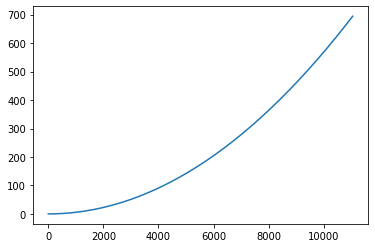

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])


    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
############################################################    

   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
    return ans 

In [104]:
q0

array([  0.        ,  55.54112987, 111.08225974, ...,   0.        ,
         0.        ,   0.        ])

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([  0.        ,  55.54112987, 111.08225974, ...,   0.        ,
         0.        ,   0.        ])

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 55.541129871666435,
 111.08225974333287,
 166.6233896149993,
 222.16451948666574,
 277.70564935833215,
 333.2467792299986,
 388.78790910166504,
 444.3290389733315,
 499.8701688449979,
 555.4112987166643,
 610.9524285883308,
 666.4935584599972,
 722.0346883316637,
 777.5758182033301,
 833.1169480749966,
 888.658077946663,
 944.1992078183293,
 999.7403376899958,
 1055.2814675616623,
 1110.8225974333286,
 1166.363727304995,
 1221.9048571766616,
 1277.445987048328,
 1332.9871169199944,
 1388.5282467916609,
 1444.0693766633274,
 1499.6105065349936,
 1555.1516364066601,
 1610.6927662783266,
 1666.2338961499931,
 1721.7750260216594,
 1777.316155893326,
 1832.8572857649924,
 1888.3984156366587,
 1943.9395455083252,
 1999.4806753799917,
 2055.021805251658,
 2110.5629351233247,
 2166.104064994991,
 2221.645194866657,
 2277.186324738324,
 2332.72745460999,
 2388.2685844816565,
 2443.809714353323,
 2499.3508442249895,
 2554.891974096656,
 2610.4331039683225,
 2665.9742338399888,
 2721.51536

In [109]:
x0_

array([    0.        ,    55.54112987,   111.08225974,   166.62338961,
         222.16451949,   277.70564936,   333.24677923,   388.7879091 ,
         444.32903897,   499.87016884,   555.41129872,   610.95242859,
         666.49355846,   722.03468833,   777.5758182 ,   833.11694807,
         888.65807795,   944.19920782,   999.74033769,  1055.28146756,
        1110.82259743,  1166.3637273 ,  1221.90485718,  1277.44598705,
        1332.98711692,  1388.52824679,  1444.06937666,  1499.61050653,
        1555.15163641,  1610.69276628,  1666.23389615,  1721.77502602,
        1777.31615589,  1832.85728576,  1888.39841564,  1943.93954551,
        1999.48067538,  2055.02180525,  2110.56293512,  2166.10406499,
        2221.64519487,  2277.18632474,  2332.72745461,  2388.26858448,
        2443.80971435,  2499.35084422,  2554.8919741 ,  2610.43310397,
        2665.97423384,  2721.51536371,  2777.05649358,  2832.59762345,
        2888.13875333,  2943.6798832 ,  2999.22101307,  3054.76214294,
      

In [110]:
z0

[0.0,
 0.01751246961451018,
 0.07004988545928607,
 0.15761226838161127,
 0.28019965323126006,
 0.43781208874315813,
 0.6304496376156087,
 0.8581123764320664,
 1.1208003957393635,
 1.4185138000085964,
 1.7512527076351265,
 2.119017250899466,
 2.5218075761041754,
 2.9596238433978517,
 3.4324662268924713,
 3.9403349146242737,
 4.48323010857332,
 5.061152024604823,
 5.67410089256693,
 6.322076956212493,
 7.005080473199078,
 7.723111715167178,
 8.476170967642444,
 9.264258530094343,
 10.087374715936166,
 10.94551985248591,
 11.838694281005393,
 12.76689835670026,
 13.730132448661296,
 14.728396939981787,
 15.761692227601051,
 16.8300187224609,
 17.9333768493883,
 19.071767047173584,
 20.2451897685118,
 21.453645480041825,
 22.697134662326786,
 23.975657809893196,
 25.289215431152716,
 26.637808048460826,
 28.021436198155953,
 29.440100430422543,
 30.89380130944755,
 32.382539413322625,
 33.90631533408324,
 35.46512967768914,
 37.05898306404388,
 38.68787612697529,
 40.35180951423546,
 42.05

In [111]:
z0_

array([0.00000000e+00, 1.75124696e-02, 7.00498855e-02, 1.57612268e-01,
       2.80199653e-01, 4.37812089e-01, 6.30449638e-01, 8.58112376e-01,
       1.12080040e+00, 1.41851380e+00, 1.75125271e+00, 2.11901725e+00,
       2.52180758e+00, 2.95962384e+00, 3.43246623e+00, 3.94033491e+00,
       4.48323011e+00, 5.06115202e+00, 5.67410089e+00, 6.32207696e+00,
       7.00508047e+00, 7.72311172e+00, 8.47617097e+00, 9.26425853e+00,
       1.00873747e+01, 1.09455199e+01, 1.18386943e+01, 1.27668984e+01,
       1.37301324e+01, 1.47283969e+01, 1.57616922e+01, 1.68300187e+01,
       1.79333768e+01, 1.90717670e+01, 2.02451898e+01, 2.14536455e+01,
       2.26971347e+01, 2.39756578e+01, 2.52892154e+01, 2.66378080e+01,
       2.80214362e+01, 2.94401004e+01, 3.08938013e+01, 3.23825394e+01,
       3.39063153e+01, 3.54651297e+01, 3.70589831e+01, 3.86878761e+01,
       4.03518095e+01, 4.20507839e+01, 4.37847999e+01, 4.55538583e+01,
       4.73579597e+01, 4.91971050e+01, 5.10712947e+01, 5.29805296e+01,
      

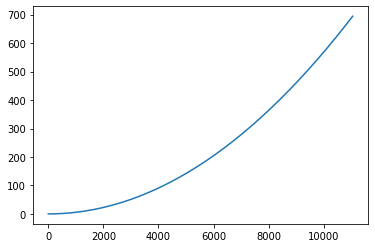

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[j*node_N-1]=0.13  

In [114]:
q0

array([  0.        ,  55.54112987, 111.08225974, ...,   0.        ,
         0.        ,   0.        ])

### Dynamics

In [115]:
def grayscott1d(t, Q):
    
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[(x0_[-1]-x[-1]),y[-1],(z0[-1]-z[-1]),φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)
 
 
    
    # PD controller after 5 sec
    if t<5:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left 
                            + tau(η, dη, wave_coef, 0, 0, t).astype(np.float32)
                            , rcond=None)[0]
    else:
        ddη=np.linalg.lstsq(V.M.astype(np.float32), -left.astype(np.float32) 
                            + tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                            , rcond=None)[0]

    tau_force = V.tau(η,dη,ddη).astype(np.float32) # /1e3


    Z0=np.dot(Re_b(Ret),tau_force[:3].reshape(3,1))

    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0.squeeze())

############################################################    
    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N-1)]+[vessel_mass],RRRR),Z).T
############################################################    

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 

#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    
    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [116]:
tspan = (0., 40)

In [117]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1, atol=1
            )
print(datetime.now() - startTime1)

KeyboardInterrupt: 

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()